# Algoritmos de clasificación para imagenes de perros y gatos
El objetivo del presente __notebook__ será desarrollar algunos algoritmos de clasificación, que nos permitan entrenar a la máquina para que pueda reconocer a partir de imágenes, a un perro o un gato. Se cuenta con una base de datos de imágenes con 99 gatos y con 99 perros, de 69 x 69 pixeles en escala de grises.  

Empezamos por cargar los datos. Cada fila representa a exáctamente un animal.

In [2]:
load("gatosperros.RData")
head(dm)

23,23,20,20,9,9,9,4,4,4,...,108,108,108,108,89,65,51,31,23,9
250,250,250,244,244,244,244,244,232,232,...,244,244,244,232,244,244,244,244,232,244
137,137,137,144,151,151,151,158,151,151,...,74,89,89,78,78,78,100,102,124,124
55,55,55,55,55,55,55,55,55,55,...,45,45,45,45,45,45,45,37,45,52
173,173,173,173,158,158,158,158,153,149,...,45,64,64,48,48,77,98,64,45,45
18,18,18,13,13,13,18,22,18,13,...,70,85,85,85,85,70,70,62,62,70


Incluímos una función que nos permite representar cada vector fila como una imagen real

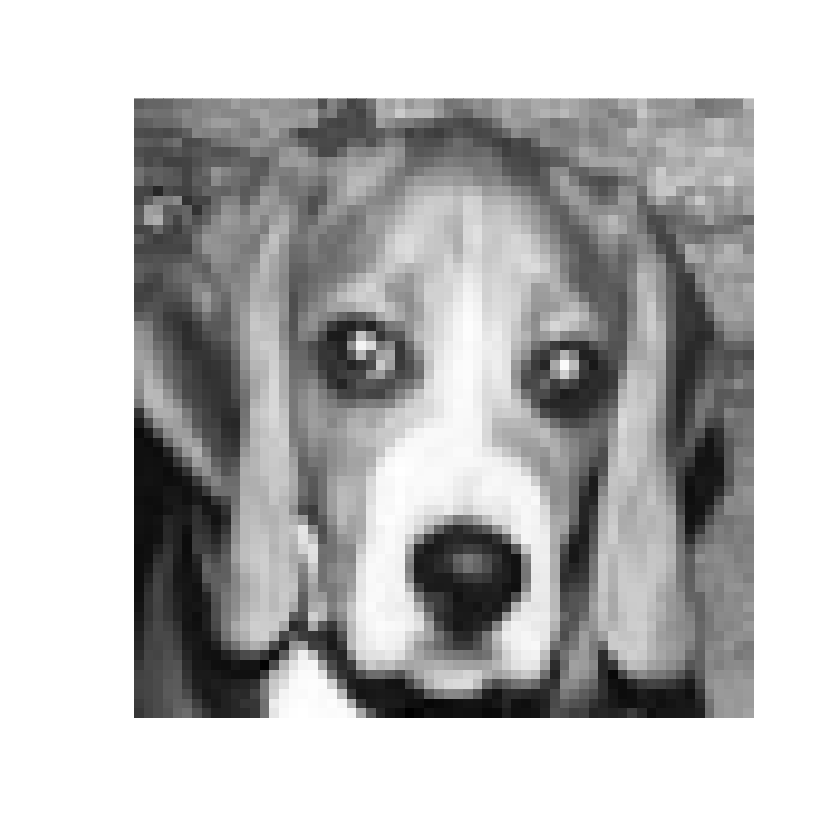

In [6]:
plotcd <- function(v){
  x <- matrix(v,64,64)
  image(1:65,1:65,t(apply(x,2,rev)),asp=1,xaxt="n",yaxt="n",
        col=grey((0:255)/255),ann=FALSE,bty="n")
}
plotcd(dm[sample(1:198,1),])

## A. Conjuntos de entrenamiento y prueba
A continuación procedemos a realizar una partición del conjunto de datos.

In [7]:
### Partición Conjuntos Entrenamiento y Prueba.
set.seed(1234)
ind.gatostest <- sample(1:99, 18, replace = FALSE)
gatos.test <- dm[ind.gatostest, ]
gatos.train <- dm[1:99, ][-ind.gatostest, ]

ind.perrostest <- sample(1:99, 18, replace = FALSE)
perros.test <- dm[100:198, ][ind.perrostest, ]
perros.train <- dm[100:198, ][-ind.perrostest, ]

## Conjuntos completos de entrenamiento y prueba
train <- rbind(gatos.train, perros.train)
y_train <- c(rep(1, 81), rep(0, 81))

test <- rbind(gatos.test, perros.test)
y_test <- c(rep(1, 18), rep(0, 18))


## B. Aplicación de componentes principales 
El objetivo consiste en realizar una reducción de la dimensionalidad de los datos, de tal manera que se logre conservar gran parte de la variabilidad en una menos cantidad de componentes.

[1] 4

[1] 24

[1] 51

[1] 80

[1] 131

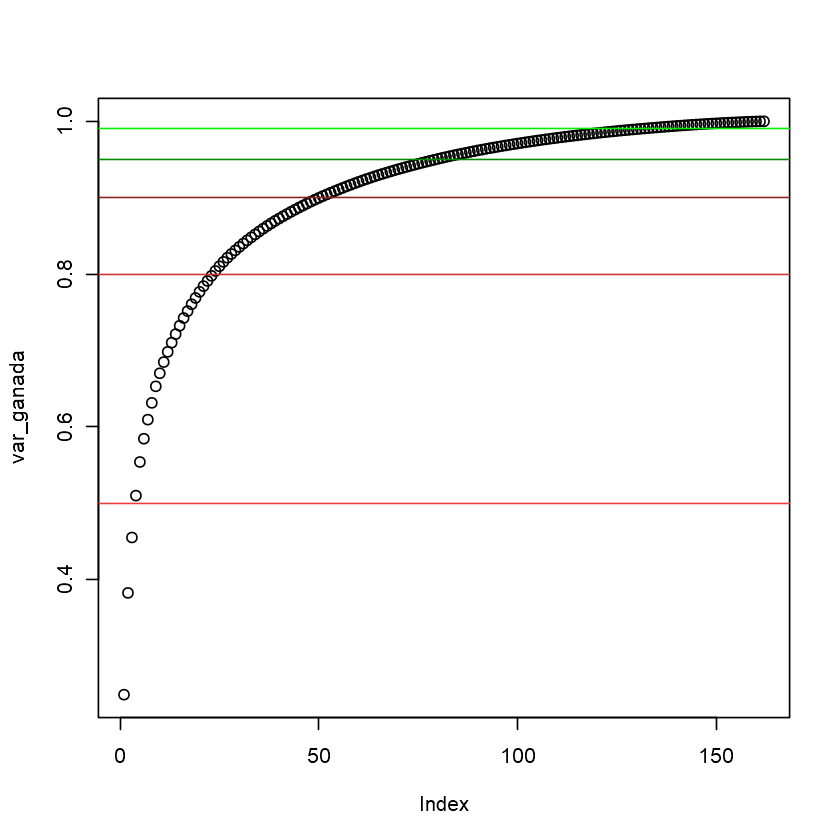

In [8]:
### Aplicación de componentes principales
pc <- prcomp(train, scale = T)

## varianza ganada
var_ganada <- cumsum(pc$sdev^2)/sum(pc$sdev^2)
plot(var_ganada)
abline(h=0.5, col="brown2")
abline(h=0.8, col="brown3")
abline(h=0.9, col="brown4")
abline(h=0.95, col="green4")
abline(h=0.99, col="green2")

which(var_ganada>0.5)[1] # 4 componentes
which(var_ganada>0.8)[1] # 24 componentes
which(var_ganada>0.9)[1] # 51 componentes
which(var_ganada>0.95)[1] # 80 componentes
which(var_ganada>0.99)[1] # 131 componentes

Como parte de un ejercicio práctico, deseamos entrenar el algoritmo con únicamente las dos primeras componentes principales. El siguiente gráfico muestra la proyección de cada perro y gato en el plano definido por las dos primeras componentes principales:

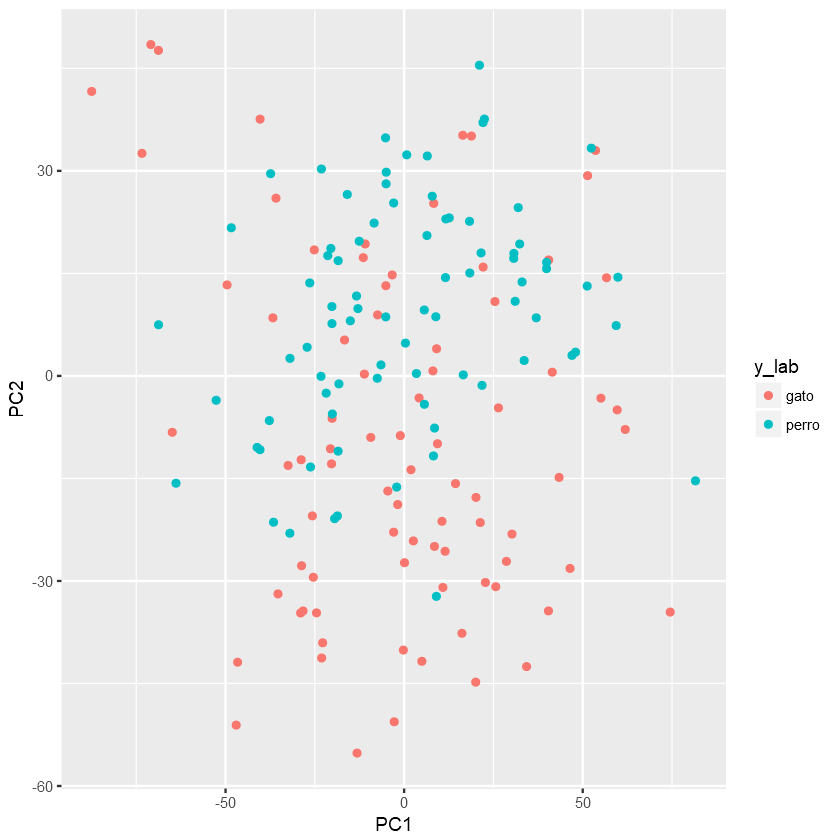

In [9]:
dos_dim <- pc$x[, 1:2]
dos_dim <- as.data.frame(dos_dim)
y_lab <- ifelse(y_train==1, "gato", "perro")

library(ggplot2)
ggplot(as.data.frame(dos_dim), aes(PC1, PC2)) + geom_point(aes(colour=y_lab))

### KNN - Vecinos mas cercanos
A continuación podemos observar la aplicación del algoritmo basado en vecinos mas cercanos, para $k=3...5$



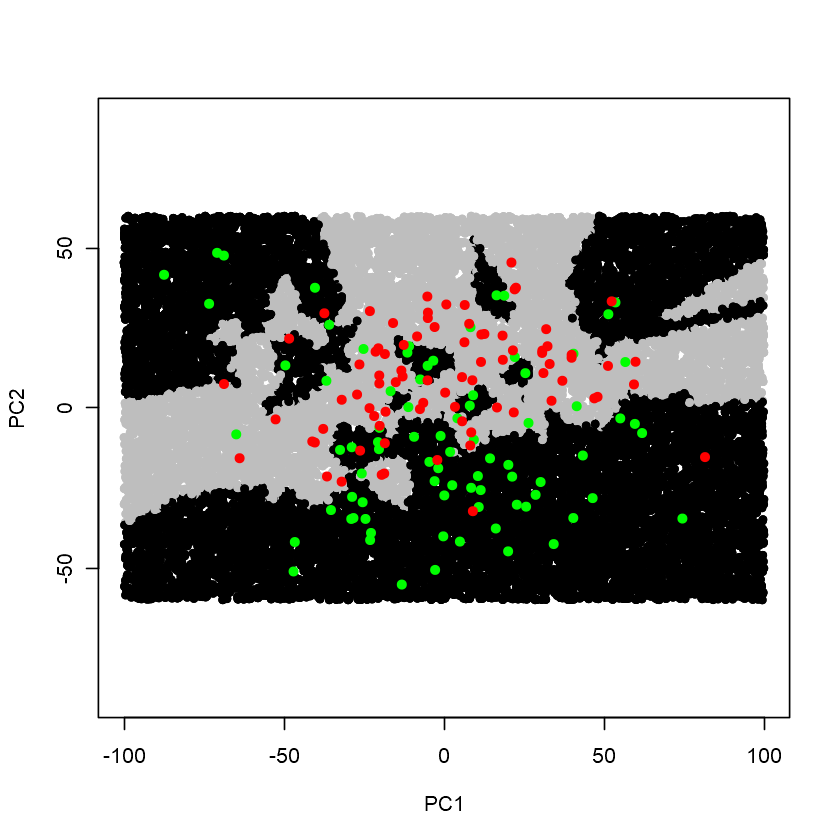

In [10]:
## Límites de simulación
lims <- c(-100, 100,#Estatura, eje X
          -60, 60) #Peso, eje Y

## Función generadora de puntos
nuevopunto <- function(lims=lims){
     a <- runif(1,lims[1],lims[2])
     b <- runif(1,lims[3],lims[4])
     return(c(a, b))
}

#*****************
## 3-Vecinos
#*****************
## Gráfico
plot(dos_dim$PC1, dos_dim$PC2, type = "n", xlab="PC1", ylab="PC2",asp=1,
     xlim=lims[1:2],ylim=lims[3:4])

## K-vecinos a considerar
k <- 3

## Algoritmo de clasificación
for(iter in 1:20000){
     x <- nuevopunto(lims)
     diss <- dist(rbind(x,dos_dim[,1:2]))[1:length(y_lab)]
     knn <- head(order(diss),k)
     etiqueta <- names(sort(table(y_lab[knn]),decreasing = TRUE))[1]
     clase <- as.numeric(etiqueta=="gato")
     for(inn in 1:k){
          if(y_lab[knn[inn]]==etiqueta){
               points(x[1],x[2],col=c("gray","black")[clase+1],pch=20)
          }
     }
}

## Datos de entrenamiento
cols2 <- rep("red", length(y_lab))
cols2[which(y_lab=="gato")] <- "green"
points(dos_dim$PC1, dos_dim$PC2, pch=16, col=cols2)


Considerando ahora $k=5$

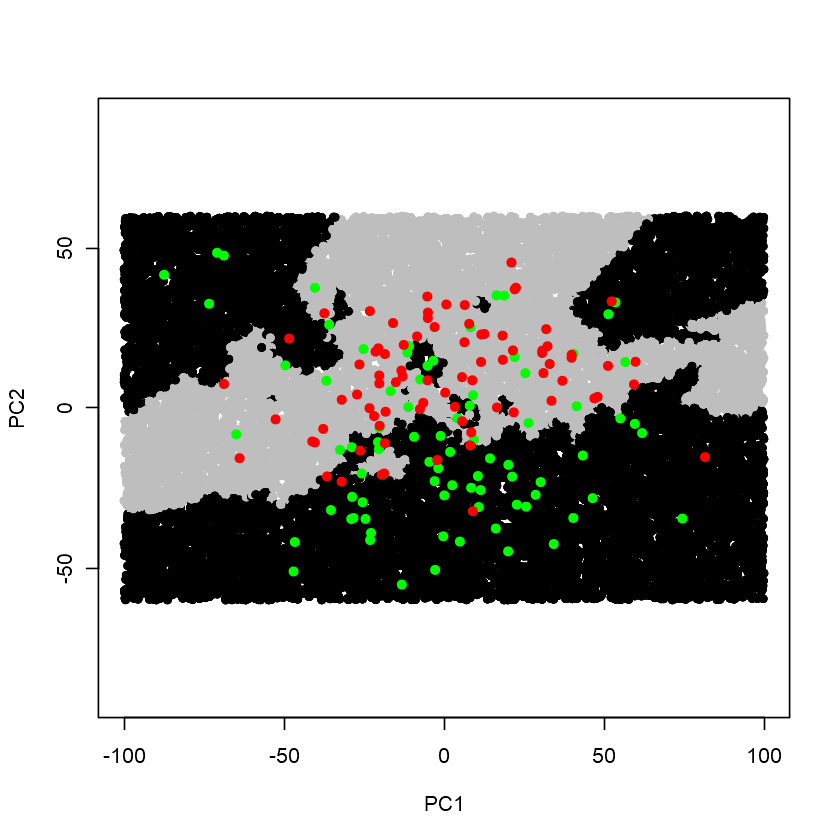

In [11]:
#*****************
## 5-Vecinos
#*****************
## Gráfico
plot(dos_dim$PC1, dos_dim$PC2, type = "n", xlab="PC1", ylab="PC2",asp=1,
     xlim=lims[1:2],ylim=lims[3:4])

## K-vecinos a considerar
k <- 5

## Algoritmo de clasificación
for(iter in 1:20000){
     x <- nuevopunto(lims)
     diss <- dist(rbind(x,dos_dim[,1:2]))[1:length(y_lab)]
     knn <- head(order(diss),k)
     etiqueta <- names(sort(table(y_lab[knn]),decreasing = TRUE))[1]
     clase <- as.numeric(etiqueta=="gato")
     for(inn in 1:k){
          if(y_lab[knn[inn]]==etiqueta){
               points(x[1],x[2],col=c("gray","black")[clase+1],pch=20)
          }
     }
}

## Datos de entrenamiento
cols2 <- rep("red", length(y_lab))
cols2[which(y_lab=="gato")] <- "green"
points(dos_dim$PC1, dos_dim$PC2, pch=16, col=cols2)

### Clasificador basado en perceptrón
Definimos ahora un clasificador a partir de la siguiente función perceptrón

In [13]:
## Función perceptrón
perceptron <- function(x, y, num_pc=24, iter) {
     # Toma las componentes dadas por num_pc
     x <- x[, 1:num_pc]
     
     # pesos iniciales
     w <- rep(0, dim(x)[2] + 1)
     # Vector de errores
     err <- rep(0, iter)
     
     # Bucle para completar todas las iteraciones
     for (i in 1:iter) {
          # Bucle que recorre todos los individuos
          for (j in 1:length(y)) {
               
               # Función de paso
               z <- sum(w[2:length(w)] * as.numeric(x[j, ])) + w[1]
               if(z > 0) {
                    ypred <- 1
               } else {
                    ypred <- 0
               }
               
               # Regla de aprendizaje del perceptrón simple
               w <- w + 1 * (y[j] - ypred) * c(1, as.numeric(x[j, ]))
               
               # Función que calcula el error de cada iteración
               if ((y[j] - ypred) != 0.0) {
                    err[i] <- err[i] + 1
               }
          }
          
          # W bolsillo
          if(i == 1){
               w.bolsillo <- w
          } else{
               if(err[i] < err[i-1]){
                    w.bolsillo <- w
               }
          }
     }
     resultados <- list(w.bolsillo=w.bolsillo, errores = err)
     return(resultados)
}


Se calcula el PERCEPTRÓN para todas las componentes principales, desde 2 hasta 162.

In [14]:
## Total de componentes
max_pca <- dim(pc$x)[1]

## Matriz pca
pca_train <- pc$x

## iteraciones para encontrar mejor perceptrón
total_pca <- list()
Num_CP <- NULL
error_train <- NULL
for(i in 2:max_pca){
     per_res <- perceptron(x = pca_train, y = y_train, num_pc = i, iter=1000)
     error_train <- c(error_train, min(per_res$errores))
     Num_CP <- c(Num_CP, i) 
     total_pca[[i-1]] <- per_res
     names(total_pca)[i-1] <- paste0("PC_", i)
}

Con los siguientes resultados:

Num_CP,error_train
2,0.2962963
3,0.2037037
4,0.2037037
5,0.2160494
6,0.1975309
7,0.1851852


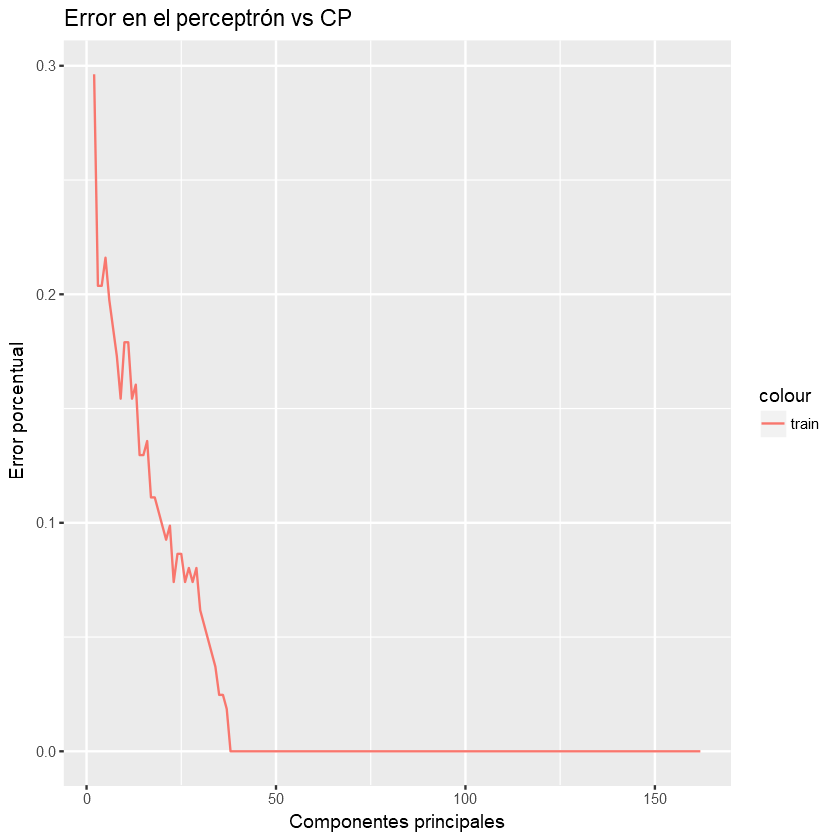

In [15]:
## Genera tabla de resultados
## La siguiente tabla muestra el error bolsillo para cada conjunto de componentes principales
tabla_res <- data.frame(Num_CP=Num_CP, error_train=error_train/length(y_train))
head(tabla_res)

## Gráfico de los resultados
## Se muestra el número de componentes usadas vs error bolsillo resultante 
require(ggplot2)
ggplot(data=tabla_res, aes(x=Num_CP, y=error_train, colour="train")) + geom_line() +
     ggtitle("Error en el perceptrón vs CP") + xlab("Componentes principales") +
     ylab("Error porcentual")

Aplicamos los resultados de cada **perceptrón** para clasificar a los perros y gatos del conjunto de pruebas

In [16]:
## Estimamos pca para el conjunto de prueba
pca_test <- predict(pc, newdata = test)

# iniciamos Vector de errores en cero
err_test <- rep(0, length(total_pca))

# etiquetas del conjunto de pruebas para evaluar predicciones
y <- y_test

for(i in 2:max_pca){
     # W bolsillo del entrenamiento
     w <- total_pca[[i-1]]$w.bolsillo
     
     # Selección de componentes a utilizar del conjunto pca_test
     x <- pca_test[, 1:i]
     
     # Bucle que recorre cada individuo de la base de prueba
     for(j in 1:length(y)){
          z <- sum(w[2:length(w)] * as.numeric(x[j, ])) + w[1]
          if(z > 0) {
               ypred <- 1
          } else {
               ypred <- 0
          }
          
          # Función que calcula el error de cada iteración
          if ((y[j] - ypred) != 0.0) {
               err_test[i-1] <- err_test[i-1] + 1
          }
     }
     
}

## Genera tabla de resultados
# Se incluye error en conjunto de prueba
tabla_res$error_test <- err_test/length(y_test)
head(tabla_res)


Num_CP,error_train,error_test
2,0.2962963,0.3055556
3,0.2037037,0.3055556
4,0.2037037,0.3611111
5,0.2160494,0.2222222
6,0.1975309,0.3055556
7,0.1851852,0.3055556


Finalmente podemos realizar un contraste entre los resultados sobre los conjuntos de prueba y entrenamiento:

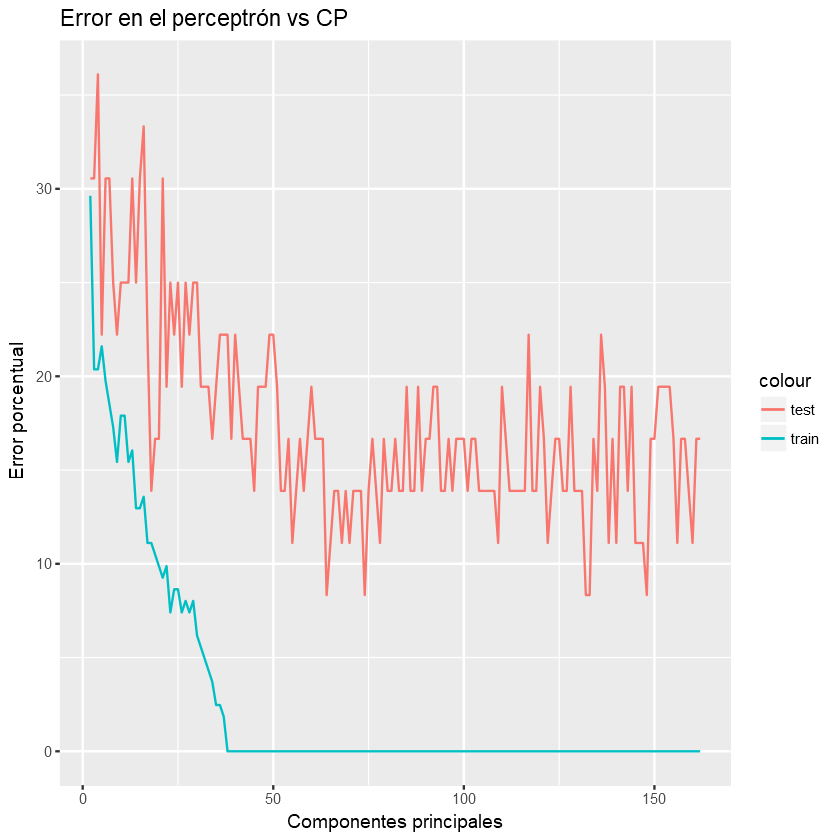

In [17]:
## Gráfico de los resultados
## Se contrasta el error de los conjuntos de entrenamiento y pruebs
require(ggplot2)
ggplot(data=tabla_res, aes(x=Num_CP, y=error_train*100, colour="train")) + geom_line() +
     geom_line(aes(x=Num_CP, y=error_test*100, colour="test")) +
     ggtitle("Error en el perceptrón vs CP") + xlab("Componentes principales") +
     ylab("Error porcentual")


Determinamos ahora el número de componentes que genera el menor error en el conjunto de prueba. Se evidencia que con 64 componentes principales, se encuentra un error mínimo del 8.33%

In [20]:
tabla_res[which.min(tabla_res$error_test), ]


,Num_CP,error_train,error_test
63,64,0,0.08333333



Con dicho número de componentes se conserva el 92.78% de la variabilidad

In [21]:
## Variabilidad ganada
var_ganada[64]

[1] 0.9278614